In [1]:
# Installation
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth
!pip install lm-eval

In [2]:
# Imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
from unsloth import FastLanguageModel, UnslothTrainer, UnslothTrainingArguments, is_bfloat16_supported
from transformers import DataCollatorForLanguageModeling
from datasets import load_dataset
from lm_eval import evaluator, models

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
# Load Llama 3 base model (4-bit) with unsloth
def load_llama_model(model_name="unsloth/llama-3-8b", max_seq_length=512):
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=model_name,
        max_seq_length=max_seq_length,
        dtype=None,
        load_in_4bit=True, # load model in 4-bit for memory efficiency
        device_map={"": 0} # map model to GPU
    )
    return model, tokenizer

model, tokenizer = load_llama_model()

==((====))==  Unsloth 2025.4.4: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [4]:
# Compute token log probabilities (logits) and Perplexity
def inference_logprobs_and_perplexity(model, tokenizer, prompt, max_new_tokens=32, top_k=10):
    FastLanguageModel.for_inference(model) # put model in inference mode
    device = model.device
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    # generate output with scores
    output = model.generate(
        input_ids,
        max_new_tokens=max_new_tokens,
        return_dict_in_generate=True,
        output_scores=True
    )

    generated_ids = output.sequences
    new_ids = generated_ids[:, input_ids.shape[-1]:]
    scores = output.scores
    topk_list = []
    log_prob_total = 0.0

    # loop over tokens and extract log probs
    for i, score in enumerate(scores):
        log_probs = F.log_softmax(score, dim=-1) # convert logits to log probabilities
        token_id = new_ids[0][i].item()
        token_log_prob = log_probs[0, token_id].item()
        log_prob_total += token_log_prob

        # get top-k alternative tokens
        top_values, top_indices = torch.topk(log_probs[0], top_k)
        top_tokens = [tokenizer.decode([idx]) for idx in top_indices.tolist()]
        top_log_probs = top_values.tolist()
        chosen_index = top_indices.tolist().index(token_id) if token_id in top_indices else -1
        topk_list.append((top_tokens, top_log_probs, chosen_index))

    avg_log_prob = log_prob_total / len(new_ids[0]) # average log prob
    perplexity = math.exp(-avg_log_prob) # Perplexity
    full_output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return full_output, topk_list, log_prob_total, perplexity

In [5]:
# Visualise token and log probabilities
def plot_token_log_probs(top10_list, prompt):

    # Plot for at most 5 generated tokens
    n = min(5, len(top10_list))
    fig, axes = plt.subplots(n, 1, figsize=(8, 3 * n))
    if n == 1:
        axes = [axes]

    for i in range(n):
        labels = top10_list[i][0]           # top-k token strings
        log_probs = top10_list[i][1]        # their log-probabilities
        chosen_index = top10_list[i][2]     # index of the selected token in top-k, or -1

        # Colour coding: red for chosen token (if in top-k), blue otherwise
        colors = ['blue'] * len(labels)
        if 0 <= chosen_index < len(colors):
            colors[chosen_index] = 'red'
            legend_note = "Chosen token shown in red"
        else:
            legend_note = "Chosen token not in top-k"

        # Draw bar chart
        axes[i].bar(labels, log_probs, color=colors)
        axes[i].set_title(f"Token {i+1} from prompt: \"{prompt}\" (log probs)\n{legend_note}")
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


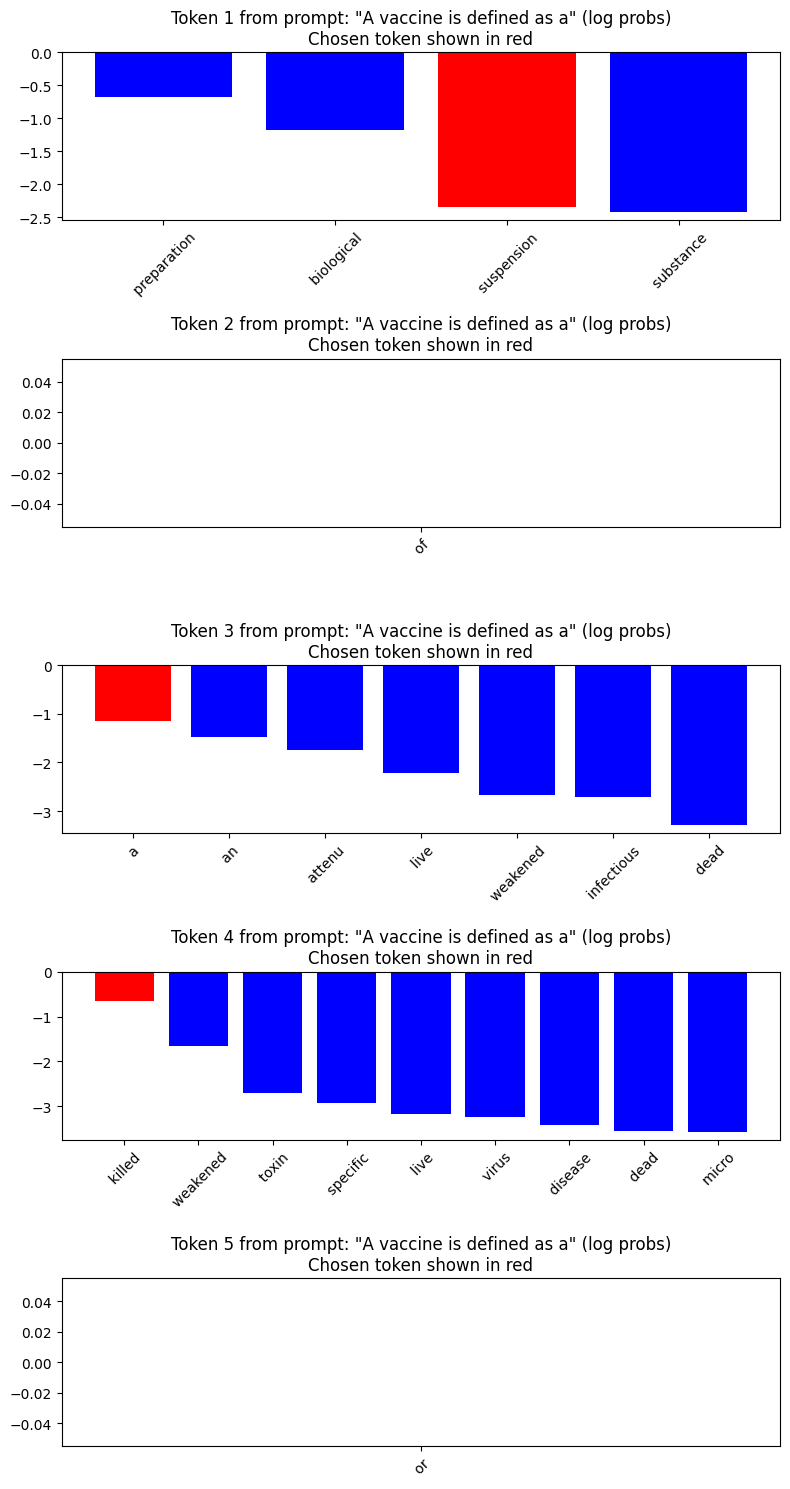

Base Model Log Probability: -25.8667, Perplexity: 2.2442


In [6]:
# Evaluate prompt continuation
prompt = "A vaccine is defined as a"

# Base Model Evaluation
out_base, topk_base, logprob_base, perplexity_base = inference_logprobs_and_perplexity(model, tokenizer, prompt)
plot_token_log_probs(topk_base, prompt)
print(f"Base Model Log Probability: {logprob_base:.4f}, Perplexity: {perplexity_base:.4f}")

In [7]:
# Evaluate on Hella-Swag benchmark and display log probabilities per choice
def hellaswag_logprobs(model, tokenizer, num_examples=3):
    dataset = load_dataset("hellaswag", split=f"validation[:{num_examples}]")
    model.eval()
    device = model.device

    for i, item in enumerate(dataset):
        ctx, endings, gold = item["ctx"], item["endings"], int(item["label"])
        print(f"\n=== Example {i+1} ===\nContext: {ctx}\n")
        log_probs = []

        for j, option in enumerate(endings):
            full_input = ctx.strip() + " " + option.strip()
            inputs = tokenizer(full_input, return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                log_probs_tensor = F.log_softmax(logits, dim=-1)

            input_ids = inputs.input_ids[0]
            log_prob_sum = sum(
                log_probs_tensor[0, k - 1, input_ids[k]].item()
                for k in range(1, len(input_ids))
            )
            log_probs.append(log_prob_sum)

            # Label correct option
            label = " (correct answer)" if j == gold else ""
            print(f"  Option {j}: {option}")
            print(f"    Log probability: {log_prob_sum:.4f}{label}")

        pred = int(torch.tensor(log_probs).argmax())

        print(f"\n Model prediction: Option {pred}")
        print(f" Correct answer:   Option {gold}")
        print(" Result:", "Correct prediction" if pred == gold else "Incorrect prediction")

print("\nEvaluating base model on HellaSwag")
hellaswag_logprobs(model, tokenizer)


Evaluating base model on HellaSwag

=== Example 1 ===
Context: A man is sitting on a roof. he

  Option 0: is using wrap to wrap a pair of skis.
    Log probability: -75.1353
  Option 1: is ripping level tiles off.
    Log probability: -68.3618
  Option 2: is holding a rubik's cube.
    Log probability: -51.3751
  Option 3: starts pulling up roofing on a roof.
    Log probability: -70.0850 (correct answer)

 Model prediction: Option 2
 Correct answer:   Option 3
 Result: Incorrect prediction

=== Example 2 ===
Context: A lady walks to a barbell. She bends down and grabs the pole. the lady

  Option 0: swings and lands in her arms.
    Log probability: -103.8286
  Option 1: pulls the barbell forward.
    Log probability: -87.7178
  Option 2: pulls a rope attached to the barbell.
    Log probability: -92.5637
  Option 3: stands and lifts the weight over her head.
    Log probability: -90.8489 (correct answer)

 Model prediction: Option 1
 Correct answer:   Option 3
 Result: Incorrect pr

In [8]:
# Fine-tune on MEDMCQA corpus
def format_medmcqa_for_finetuning(example):
    # format each question as a prompt + correct answer
    prompt = f"Question: {example['question']}\nA) {example['opa']} B) {example['opb']} C) {example['opc']} D) {example['opd']}\nAnswer:"
    completion = f" {example['cop']}"
    return {"text": prompt + completion}

def fine_tune_medmcqa(base_model, tokenizer, nsamples=100):
    # load a small subset of the MedMCQA dataset
    dataset = load_dataset("medmcqa", split=f"train[:{nsamples}]")
    dataset = dataset.map(format_medmcqa_for_finetuning)
    dataset = dataset.remove_columns([col for col in dataset.column_names if col != "text"])

    # apply LoRA-based parameter-efficient tuning
    model = FastLanguageModel.get_peft_model(
        base_model,
        r=16,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
        lora_alpha=16,
        lora_dropout=0,
        bias="none",
        use_gradient_checkpointing="unsloth",
        random_state=42
    )

    # define training configuration
    trainer = UnslothTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=dataset,
        dataset_text_field="text",
        max_seq_length=512,
        dataset_num_proc=2,
        data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False),
        args=UnslothTrainingArguments(
            per_device_train_batch_size=2,
            gradient_accumulation_steps=4,
            max_steps=20,
            learning_rate=2e-4,
            fp16=not is_bfloat16_supported(),
            bf16=is_bfloat16_supported(),
            logging_steps=1,
            output_dir="outputs",
            report_to="none"
        )
    )

    # perform training
    trainer.train()
    return model, tokenizer

# Fine-tune the base model
model_finetuned, tokenizer_finetuned = fine_tune_medmcqa(model, tokenizer, nsamples=100)

Unsloth 2025.4.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100 | Num Epochs = 2 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,2.431000
2,1.817800
3,1.658700
4,1.678100
5,1.638700
6,1.508100
7,1.227600
8,1.461500
9,1.526900
10,1.666500


Unsloth: Will smartly offload gradients to save VRAM!


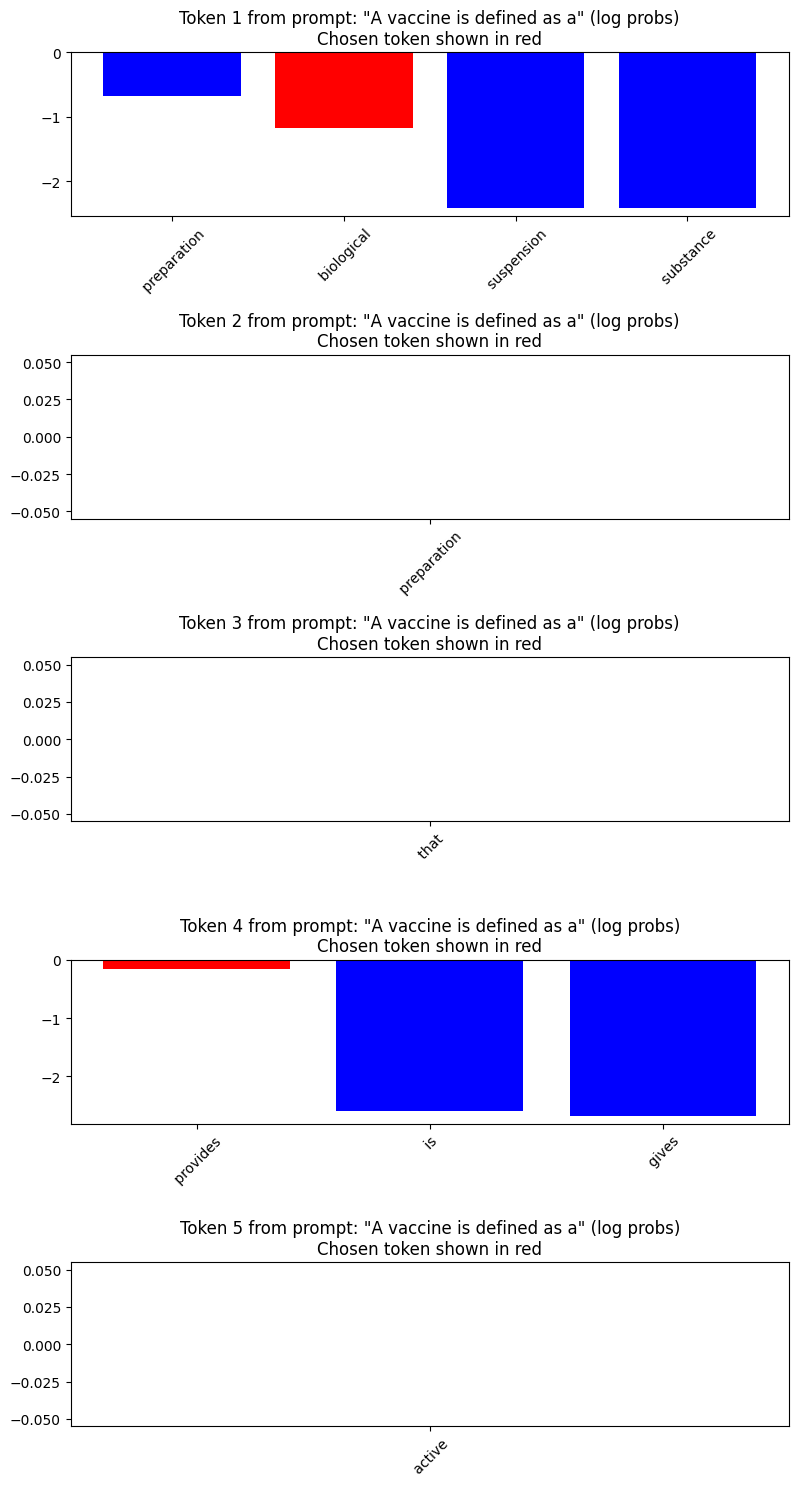

Prompt: A vaccine is defined as a
Base model:
A vaccine is defined as a suspension of a killed or weakened organism or a portion of an organism, which produces immunity against a disease when administered to a person. The word vaccine comes from the
Log probability (base): -25.8667
Perplexity (base): 2.2442

Fine-tuned model:
A vaccine is defined as a biological preparation that provides active acquired immunity to a particular disease. Vaccines are administered by injection or orally and are used to prevent infectious diseases. The vaccine is developed
Log probability (fine-tuned): -20.8967
Perplexity (fine-tuned): 1.9213


In [9]:
# Final Evaluation - Compare base vs fine-tuned model
# Base model was evaluated earlier before fine-tuning

# Evaluate fine-tuned model
out_ft, topk_ft, logprob_ft, perplexity_ft = inference_logprobs_and_perplexity(model_finetuned, tokenizer_finetuned, prompt)
plot_token_log_probs(topk_ft, prompt)

print("Prompt:", prompt)
print("Base model:")
print(out_base)
print(f"Log probability (base): {logprob_base:.4f}")
print(f"Perplexity (base): {perplexity_base:.4f}\n")

print("Fine-tuned model:")
print(out_ft)
print(f"Log probability (fine-tuned): {logprob_ft:.4f}")
print(f"Perplexity (fine-tuned): {perplexity_ft:.4f}")

In [10]:
# Final Evaluation on Benchmark (Post Fine-tuning)

# Re-evaluate on Hellaswag benchmark
print("\nEvaluating fine-tuned model on HellaSwag")
hellaswag_logprobs(model_finetuned, tokenizer_finetuned)


Evaluating fine-tuned model on HellaSwag

=== Example 1 ===
Context: A man is sitting on a roof. he

  Option 0: is using wrap to wrap a pair of skis.
    Log probability: -74.4510
  Option 1: is ripping level tiles off.
    Log probability: -68.3168
  Option 2: is holding a rubik's cube.
    Log probability: -50.5150
  Option 3: starts pulling up roofing on a roof.
    Log probability: -70.1438 (correct answer)

 Model prediction: Option 2
 Correct answer:   Option 3
 Result: Incorrect prediction

=== Example 2 ===
Context: A lady walks to a barbell. She bends down and grabs the pole. the lady

  Option 0: swings and lands in her arms.
    Log probability: -103.4894
  Option 1: pulls the barbell forward.
    Log probability: -87.6258
  Option 2: pulls a rope attached to the barbell.
    Log probability: -92.3895
  Option 3: stands and lifts the weight over her head.
    Log probability: -90.6356 (correct answer)

 Model prediction: Option 1
 Correct answer:   Option 3
 Result: Incorr